# Plot Supp Figures

CC plots for random timeseries

For Sawi et al., 2021

In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from obspy.signal.cross_correlation import correlate, xcorr_max


sys.path.append('.')
sys.path.append('../src/visualization/')

import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import dateToEventID, catMergeFromH5, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Define helper functions (move later)

## Set paths

In [3]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']


path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathAuxData = '../data/processed/Garcia/'

In [4]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')



## Define some important times in study period

In [5]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [6]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [7]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [8]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [9]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [10]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hour_of_approx_max_temp = 14
hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [11]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [12]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Reduce dimensionality, visualize PC plots by time, hour

* Perform PCA on FPs 
* Calculate PVE (percent variance explained) for each PC, and keep enouch PCs to capture XX% of variance
* Cluster using Kmeans 
* Choose cluster based on highest mean silhouette score


In [13]:

PCA_df, numPCA_PVE, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False);
PCA_dfN, numPCA_PVEN, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.86,stand=False)



1 0.141772319308
2 0.225535762943
3 0.277379352466
4 0.312981120783
5 0.343504148781
6 0.372574684576
7 0.39888891688
8 0.420888467097
9 0.439353048501
10 0.45641596446
11 0.472892699879
12 0.488663198754
13 0.503513438636
14 0.517374013975
15 0.530760903475
16 0.543688005688
17 0.556299393838
18 0.5684234895
19 0.580115232232
20 0.591282355233
21 0.602294676701
22 0.612605703469
23 0.622052162051
24 0.631161320527
25 0.639744013187
26 0.648315431133
27 0.657036268271
28 0.665247316001
29 0.672756648672
30 0.68065609114
31 0.687867804503
32 0.695009126046
33 0.701574944722
34 0.708809136561
35 0.715650371413
36 0.72219707484
37 0.728761455364
38 0.734869646114
39 0.741116325521
40 0.746825368462
41 0.752864600702
42 0.75835840378
43 0.763956848906
44 0.769771972114
45 0.77495614986
46 0.780036748614
47 0.784964925576
48 0.789747081872
49 0.794556319555
50 0.7993127707
51 0.803727872034
52 0.808073230563
53 0.812496068058
54 0.81650492349
55 0.82085072464
56 0.82475498226
57 0.828628421

In [14]:
print(f'\n For icequakes, {100*cum_pve:.2f}% of variance explained by the first {numPCA_PVE} principal components')
print(f'\n For noise, {100*cum_pveN:.2f}% of variance explained by the first {numPCA_PVEN} principal components')


 For icequakes, 86.34% of variance explained by the first 67 principal components

 For noise, 86.09% of variance explained by the first 3 principal components


In [15]:
stand = False #standard scalar before PCA


#returns a PCA sklearn object, a dataframe of cat00 but with columns for PCs, and a numpy array of PCs (N x numPC)

sklearn_pca, cat00, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_PVE,stand=stand)
sklearn_pcaN, cat00N, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_PVEN,stand=stand)


## Clustering using Kmeans on PCA of FP, validating using silhouette score

In [16]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_PVE,Xtype='fingerprints', distMeasure = "SilhScore",stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_PVEN,Xtype='fingerprints',distMeasure = "SilhScore", stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 3
Event optimum number of clusters::  3
kmeans on 2 clusters...
kmeans on 3 clusters...
kmeans on 4 clusters...
kmeans on 5 clusters...
kmeans on 6 clusters...
kmeans on 7 clusters...
kmeans on 8 clusters...
kmeans on 9 clusters...
kmeans on 10 clusters...
Best cluster: 4
Noise optimum number of clusters::  4


# Cross correlation between topF events

https://docs.obspy.org/master/packages/autogen/obspy.signal.cross_correlation.correlate.html
    



In [182]:
topF=25
catRep = getTopFCat(cat00,topF=topF) 

catRepN = getTopFCat(cat00N,topF=topF)

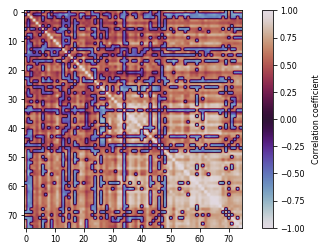

In [183]:
__ , __ = figureFunctions2.plotCCMatrix(catRep,lenData,dataH5_path,station,channel,fmin,fmax,fs)


## CC for just one cluster

0.207051632313
0.19988079301
0.181090058611
0.198003608291


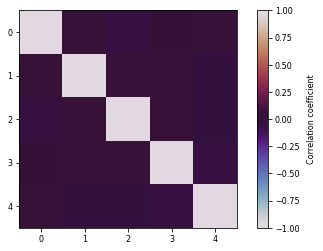

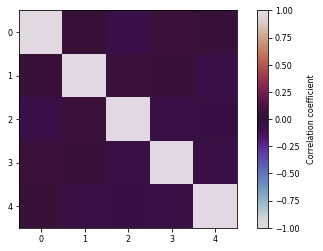

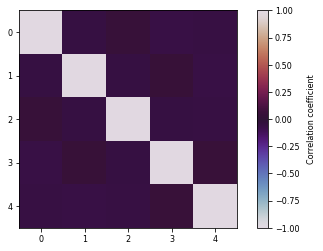

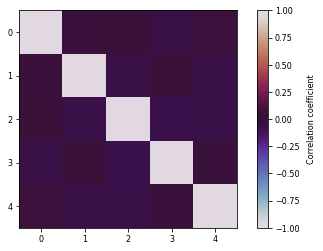

In [170]:
ccmatK_listN = []
avg_cc_listN = []

for k in range(1,KoptN+1):

    catRepK = catRepN[catRepN.Cluster==k]
    ccmatK, __ = figureFunctions2.plotCCMatrix(catRepK,lenDataN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)
    ccmatK_listN.append(ccmatK)
    avg_cc_listN.append(np.mean(ccmatK))
    print(np.mean(ccmatK))

## average off-diagonal for upper triangle entries...

In [185]:

def upper_tri_masking(A):
    '''
    Get upper triangle without diagonals
    
    Sample: 
    A = np.array([
     [1,2,3],
     [4,5,6],
     [7,8,9]])
     
    returns: np.array([2,3,6])
    '''
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

In [186]:
for k,ccmatK in enumerate(ccmatK_list):

    upTri_cc = upper_tri_masking(ccmatK)
    
    avg_cc = np.mean(upTri_cc)

    print(f'Cluster {k+1} avg CC:, ',avg_cc) #find CC avg

Cluster 1 avg CC:,  0.163701785282
Cluster 2 avg CC:,  0.297056103072
Cluster 3 avg CC:,  0.71325495055


In [173]:
for k,ccmatK in enumerate(ccmatK_listN):

    upTri_cc = upper_tri_masking(ccmatK)
    
    avg_cc = np.mean(upTri_cc)

    print(f'Cluster {k+1} avg CC:, ',avg_cc) #find CC avg

Cluster 1 avg CC:,  0.00881454039075
Cluster 2 avg CC:,  -0.000149008737044
Cluster 3 avg CC:,  -0.0236374267366
Cluster 4 avg CC:,  -0.00249548963636


In [175]:
topF=50
catRep = getTopFCat(cat00,topF)

In [177]:
# plt.rcParams['image.cmap']='twilight'


# shift_cc = lenData


# figureFunctions2.plotCCMatrix(catRep,shift_cc,dataH5_path,station,channel,fmin,fmax,fs)
# plt.savefig(pathFig + f'Supp_CC_events_{topF}.png')

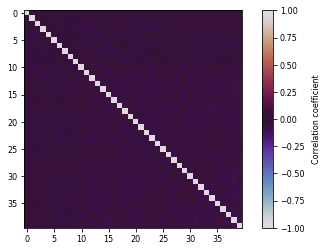

In [20]:
shift_ccN = lenDataN


cc_matN = figureFunctions2.plotCCMatrix(catRepN,shift_ccN,dataH5_pathN,station,channel,fminN,fmaxN,fsN)
plt.savefig(pathFig + 'Supp_CC_Noise.png')

In [21]:
# -------------------------------------------- from Jonathon Sheppard


from random import gauss

def generate_noise(mu, sigma, x, samples):
    """
    Generate x number of random gaussian distributions.
    
    Parameters
    ----------
    mu: <int, float>
        Mean of the distribution
    sigma: <array, list>
        Standard deviation of the distribution
    x: <int>
        Number of arrays to create
    samples: <int>
        Number of points in the distribution
    """

    wf_list = np.zeros((x,samples))
    for i in range(x):
        wf_list[i] = [gauss(mu, sigma[i]) for j in range(samples)]
    npts = x
    
    return wf_list



In [22]:
Nx = 40 #number of waveforms
Nsigma = 1 * np.ones(Nx) #array of std for gaussians for waveforms
mu = 0 #mean of gauss
wf_list = generate_noise(mu=mu, sigma=Nsigma, x=Nx, samples=lenDataN) #list of waveform arrays--- from Jonathon Sheppard
shift_cc = len(wf_list[0]) #max number of samples cross correlation can shift
plotCCMatrix_Synth(wf_list,shift_cc)
plt.savefig(pathFig + 'Supp_CC_RANDomnoise.png')

NameError: name 'plotCCMatrix_Synth' is not defined


# Comparing Kmeans on spectra 


## compile spectra caluclated from summing spectrograms

In [ ]:
## compile spectra caluclated from FFT waveform  

fSTFT_trim, X, sgram_df = compileSpectraFromWF(cat00,dataH5_path,station,channel,fmin,fmax)
fSTFT_trimN, XN, sgram_dfN = compileSpectraFromWF(cat00N,dataH5_pathN,station,channel,fminN,fmaxN)




## Calc Kmeans, force number of K if needed

In [ ]:
## Calc Kmeans, force number of K if needed

# range_n_clusters = list(range(2,Kmax+1))

range_n_clusters = [3]
sgram_df_clustered = KMeansSpectra(sgram_df,range_n_clusters)
range_n_clusters = [4]
sgram_df_clusteredN = KMeansSpectra(sgram_dfN,range_n_clusters)

## quick compare through time ? for switching labels

In [ ]:
dt = [pd.to_datetime('200' + str(evID)) for evID in sgram_df_clustered.event_ID]
sgram_df_clustered['datetime_index'] = dt
sgram_df_clustered['datetime'] = dt
sgram_df_clustered = sgram_df_clustered.set_index('datetime_index')

dt = [pd.to_datetime('200' + str(evID)) for evID in sgram_df_clusteredN.event_ID]
sgram_df_clusteredN['datetime_index'] = dt
sgram_df_clusteredN['datetime'] = dt
sgram_df_clusteredN = sgram_df_clusteredN.set_index('datetime_index')

In [ ]:
# # sgram_df_clustered2 = swapLabels(sgram_df_clustered,A,B)
# for k in range(1,Kopt+1):
#     plt.figure()
#     figureFunctions2.plotBarCluster(sgram_df_clustered,k=k,barWidth=.3,timeBin='H',ax=None,**plt_kwargs)

# sgram_df_clustered2 = swapLabels(sgram_df_clustered,A,B)
for k in range(1,KoptN+1):
    plt.figure()
    figureFunctions2.plotBarCluster(sgram_df_clusteredN,k=k,barWidth=.3,timeBin='H',ax=None,**plt_kwargs)


In [ ]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 10})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)
tfont=14

rain_df = meteor_df.rain


gs = gridspec.GridSpec(KoptN+Kopt+1,1)
gs.update(wspace=.6, hspace=.15)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  

titleN = 'Noise'
textYN = 17.5

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])
#     ax.set_ylim(0,20)
#     ax.set_ylim(ymin=0)
    figureFunctions2.plotBarCluster(sgram_df_clustered,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)
    if k == 1:

        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        ax.set_title(title,fontsize=tfont,pad=tpad)

        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    
    elif k==2:    
        ax.set_ylabel('Observations per hour',labelpad=6)    
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
            
            
    elif k==3:
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    
    else:
        figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
        
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
   

    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
        
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')



for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(ymin=0)

    figureFunctions2.plotBarCluster(sgram_df_clusteredN,k=k,barWidth=.3,ax=ax,**plt_kwargs)
    figureFunctions2.plotLake(lake_df,rain_df,legend=None,ylabel=None,ax=ax,**plt_kwargs)

    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title(titleN,fontsize=tfont,pad=tpad)
        
    if k == 2:

        ax.set_ylabel('Observations per hour',labelpad=6)            
        for e, gps_dff in enumerate(gps_df_list):
            if e==0:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='right',ax=ax,**plt_kwargs)
            else:
                figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)
    else:
        for gps_dff in gps_df_list:
            figureFunctions2.plotGPS(gps_dff.vel_fill,ylabel='none',ax=ax,**plt_kwargs)

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
plt.savefig(pathFig + f'Supp_Kmeans_Figure_9_gps.pdf',bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 12})
title = 'Icequakes'
titleN = 'Noise'
dailyTempDiff = getDailyTempDiff(meteor_df,**plt_kwargs)


tfont = 14
tpad = 16

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True)#,constrained_layout=True)

plt.suptitle('Icequakes                Noise  ',fontsize=tfont)  

gs = gridspec.GridSpec(len(catallN)+1, 2)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.5, hspace=.8)


### ICEQUAKE PROPORTION HOURLY
ax = plt.subplot(gs[0,0])

figureFunctions2.plotHourBar(sgram_df_clustered,Kopt,dailyTempDiff,ax=ax,labelpad=20,label='none',colorBy='all',k=0,**plt_kwargs)
ax.set_title(f'N={len(cat00)}', loc='left',fontsize=10,pad=1,color='k')
ax.set_ylabel('')
ax.set_xlim(0,23)
ax.set_xticklabels([]) 
ax.set_xlabel('')

### ICEQUAKES BY CLUSTER HOURLY

for k in range(1,Kopt+1):
    
    i = k
    
    ax = plt.subplot(gs[i,0])
    ax.set_title(f'n={len(sgram_df_clustered[sgram_df_clustered.Cluster==k])}', loc='left',fontsize=10,pad=1,color=colors[k-1])
    
#     figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,colorBy='cluster',k=k,**plt_kwargs)
    
    if k == 0:
        figureFunctions2.plotHourBar(sgram_df_clustered,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='right',colorBy='cluster',k=k,**plt_kwargs)
#         ax.set_title(title,fontsize=tfont,pad=tpad)  
    else:
        figureFunctions2.plotHourBar(sgram_df_clustered,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        ax.set_ylabel('')
        
    
    if k != Kopt:        
        ax.set_xlabel('')
        ax.set_xticklabels([])  
    if k == 1:
        ax.set_ylabel('Number of observations    ',labelpad=8)
    
#     ax.set_yticklabels([])  

        
        
# ### NOISE PROPORTION HOURLY
axN = plt.subplot(gs[0,1])

figureFunctions2.plotHourBar(sgram_df_clusteredN,KoptN,dailyTempDiff,ax=axN,labelpad=20,label='right',colorBy='all',k=0,**plt_kwargs)

axN.set_title(f'N={len(cat00N)}', loc='left',fontsize=10,pad=1,color='k')
axN.set_ylabel('')
axN.set_xlim(0,23)
axN.set_xticklabels([]) 
axN.set_xlabel('')

### NOISE BY CLUSTER HOURLY
for k in range(1,KoptN+1):
    
    i = k
    
    axN = plt.subplot(gs[i,1])

    axN.set_title(f'n={len(sgram_df_clusteredN[sgram_df_clusteredN.Cluster==k])}', loc='left', fontsize=10,pad=1,color=colors[k-1])
    if k == 0:
        figureFunctions2.plotHourBar(sgram_df_clusteredN,KoptN,dailyTempDiff,ax=axN,labelpad=20,label='none',colorBy='cluster',k=k,**plt_kwargs)

    if k != 1:
        figureFunctions2.plotHourBar(sgram_df_clusteredN,KoptN,dailyTempDiff,ax=axN,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        axN.set_ylabel('')
#         ax.set_yticks([])   
    else:
        figureFunctions2.plotHourBar(sgram_df_clusteredN,KoptN,dailyTempDiff,ax=axN,labelpad=8,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
    if k != KoptN:
        axN.set_xticklabels([]) 

        axN.set_xlabel('')

plt.savefig(pathFig + f'Supp_Figure_8_kmeans.pdf',bbox_inches='tight')


## Confusion matrix compare kmeans on FFT and fingerprints

In [ ]:
figureFunctions2.plotConfusionMatrix(cat00N,sgram_df_clusteredN)



In [ ]:
figureFunctions2.plotConfusionMatrix(cat00N,sgram_df_clusteredN)


In [ ]:
# figureFunctions2.plotConfusionMatrix(cat00,sgram_df_clustered2)

# Sanity check::  Calc spectra using FFT instead of summing spectrograms

In [ ]:
from matplotlib.mlab import window_hanning

##IQ

spectraFFT_list = []

for i, evID in enumerate(cat00.event_ID):
    
    c = colors[cat00.Cluster.iloc[i]-1]
    
    waveform = getWF(evID,dataH5_path,station,channel,fmin=fmin,fmax=400,fs=fs)
    
    spectrum,freqs, line =  plt.magnitude_spectrum(x=waveform, 
                                                   Fs=fs,
                                                   window=window_hanning, 
                                                   pad_to=len(waveform)*2, 
                                                   scale='dB',
                                                   sides='onesided',
                                                  color=c,
                                                  visible=True,
                                                  alpha=.04,
                                                   lw=.7)
     
    STFT_norm = spectrum / np.median(spectrum)  ##norm by median

    dB = 20*np.log10(STFT_norm, where=STFT_norm != 0)  ##convert to dB
    
    spectraFFT_list.append(dB)
    plt.xlim(fmin,fmax)
    plt.ylim(-100,100)
    plt.title('Icequakes')
    
plt.savefig(pathFig + 'Sup_SpectraFFT_IQ_FP.png')

In [ ]:
sN = []

##NOISE

for i, evID in enumerate(cat00N.event_ID):
    
    c = colors[cat00N.Cluster.iloc[i]-1]
    
    waveform = getWF(evID,dataH5_pathN,station,channel,fmin=fminN,fmax=400,fs=fsN)
    
    spectrum,freqs, line =  plt.magnitude_spectrum(x=waveform, 
                                                   Fs=fsN,
                                                   window=window_hanning, 
                                                   pad_to=len(waveform)*2, 
                                                   scale='dB',
                                                   sides='onesided',
                                                  color=c,
                                                  visible=True,
                                                  alpha=.04,
                                                  lw=.7)
    

    STFT_norm = spectrum / np.median(spectrum)  ##norm by median

    dB = 20*np.log10(STFT_norm, where=STFT_norm != 0)  ##convert to dB
    
    sN.append(dB)
    plt.xlim(fminN,fmaxN)
    plt.ylim(-175,50)
    plt.title('Noise')
    
plt.savefig(pathFig + 'Sup_SpectraFFT_NS_FP.png')